In [2]:
import pymssql
import pandas as pd

import geopandas as gpd
from shapely.geometry import Point

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from datetime import datetime
import contextily as ctx
from matplotlib.colors import LogNorm

In [3]:
plt.rcParams["figure.figsize"] = 10,7
plt.rcParams["font.size"] = 15

In [4]:

# connect to previously created server/database
conn = pymssql.connect(
    server='193.224.59.119',
    user='bokanyie',
    password='AppleTree1234',
    database='migration'
)

def get_dataframe(query):
    """
    This function uses the previous connection to execute a query
    and fetch results as pandas.DataFrame.
    """
    cursor = conn.cursor()
    cursor.execute(query)
    return pd.DataFrame([[elem if type(elem)!=str else elem.strip() for elem in i] for i in cursor], columns=[i[0] for i in cursor.description])
      
def make_geodataframe(df, geom_x = "lon", geom_y = "lat"):
    """
    This function creates a geodataframe from a regular pandas.DataFrame, given
    two lon/lat columns.
    """
    df["geometry"] = df.apply(lambda r: Point(np.array([r[geom_x],r[geom_y]])),axis=1)
    return gpd.GeoDataFrame(df, crs="epsg:4326")

# Original data

This is the original dataset we loaded into the server. Let's have a look at the top 100 rows!

In [3]:
df = get_dataframe('select top 100 * from birds_small')
df.head()

,gbifID,species,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,eventDate,day,month,year,OrganismID
0,1210856425,Larus argentatus,51.229821,2.925915,16.0,2015-05-21 18:14:30,21,5,2015,H903128
1,1210856429,Larus argentatus,51.229710,2.925822,3.0,2015-05-21 19:44:39,21,5,2015,H903128
2,1210856430,Larus argentatus,51.229635,2.925868,10.0,2015-05-21 19:18:58,21,5,2015,H903128
3,1210856434,Larus argentatus,51.229726,2.925772,5.0,2015-05-21 19:29:06,21,5,2015,H903128
4,1210856436,Larus argentatus,51.229672,2.925753,14.0,2015-05-21 18:24:58,21,5,2015,H903128


/home/bokanyie/.anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

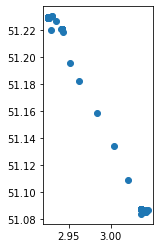

In [19]:
gdf = make_geodataframe(df, geom_x="decimalLongitude", geom_y="decimalLatitude")
gdf.plot()

# Adding an ordering of the lines

In [20]:
df = get_dataframe('select top 100 * from birds_small_timestamped')
df.head()

,OrganismID,event_timestamp,gbifID,species,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,eventDate,day,month,year
0,H903128,1432231467,1210856462,Larus argentatus,51.229343,2.925964,13.0,2015-05-21 18:04:27,21,5,2015
1,H903128,1432231767,1210856447,Larus argentatus,51.229863,2.925786,16.0,2015-05-21 18:09:27,21,5,2015
2,H903128,1432232070,1210856425,Larus argentatus,51.229821,2.925915,16.0,2015-05-21 18:14:30,21,5,2015
3,H903128,1432232409,1210856463,Larus argentatus,51.229765,2.925881,7.0,2015-05-21 18:20:09,21,5,2015
4,H903128,1432232698,1210856436,Larus argentatus,51.229672,2.925753,14.0,2015-05-21 18:24:58,21,5,2015


## Chaining consecutive events

In [3]:
df = get_dataframe('select top 100 * from birds_small_consecutive_events')
df.head()

,OrganismID,event_timestamp,previous_event_timestamp,lat,lon,previous_lat,previous_lon
0,H903128,1432231467,NaN,51.229343,2.925964,NaN,NaN
1,H903128,1432231767,1.432231e+09,51.229863,2.925786,51.229343,2.925964
2,H903128,1432232070,1.432232e+09,51.229821,2.925915,51.229863,2.925786
3,H903128,1432232409,1.432232e+09,51.229765,2.925881,51.229821,2.925915
4,H903128,1432232698,1.432232e+09,51.229672,2.925753,51.229765,2.925881


In [4]:
df = get_dataframe('select top 100 * from birds_consecutive_events_delta')
df.head()

,OrganismID,event_timestamp,delta_t,distance,velocity
0,H903128,1432231767,300,0.059172,0.710069
1,H903128,1432232070,303,0.010150,0.120596
2,H903128,1432232409,339,0.006667,0.070805
3,H903128,1432232698,289,0.013674,0.170338
4,H903128,1432232987,289,0.005950,0.074116


In [8]:
get_dataframe("""
    DECLARE @bw FLOAT = 10
    SELECT
        @bw * floor(velocity / @bw) as velocity_bin_kmh,
        COUNT(*) as cnt
    FROM
        birds_consecutive_events_delta
    GROUP BY
        @bw * floor(velocity / @bw)
    ORDER BY
        1;
""")

,velocity_bin_kmh,cnt
0,0.0,2219011
1,10.0,93270
2,20.0,98949
3,30.0,96221
4,40.0,50724
5,50.0,21964
6,60.0,7722
7,70.0,2008
8,80.0,568
9,90.0,148


In [7]:
get_dataframe("""
    DECLARE @bw FLOAT = 1
    SELECT
        @bw * floor(distance / @bw) as distance_bin_km,
        COUNT(*) as cnt
    FROM
        birds_consecutive_events_delta
    GROUP BY
        @bw * floor(distance / @bw)
    ORDER BY
        1;
""")

,distance_bin_km,cnt
0,0.0,2387058
1,1.0,94620
2,2.0,33977
3,3.0,15064
4,4.0,10734
...,...,...
116,872.0,1
117,922.0,1
118,995.0,1
119,1131.0,1


## Temporary tables for help

In [9]:
get_dataframe("select top 10 * from birds_stop_detection_temp")

,OrganismID,event_timestamp,small_delta_t,small_delta_d,both_small,valid_velocity
0,H903128,1432231767,1,1,0,1
1,H903128,1432232070,1,1,0,1
2,H903128,1432232409,1,1,0,1
3,H903128,1432232698,1,1,0,1
4,H903128,1432232987,1,1,0,1
5,H903128,1432233275,1,1,0,1
6,H903128,1432233563,1,1,0,1
7,H903128,1432233851,1,1,0,1
8,H903128,1432234151,1,1,0,1
9,H903128,1432234443,1,1,0,1


In [12]:
get_dataframe("select top 100 * from birds_stop_detection_temp2").head(30)

,OrganismID,event_timestamp,both_small,stopid,lat,lon
0,H903128,1432565393,0,57,51.083616,3.037194
1,H903128,1432565687,0,57,51.084542,3.036754
2,H903128,1432565986,0,57,51.084128,3.037184
3,H903128,1432566283,0,57,51.085209,3.037231
4,H903128,1432566577,0,57,51.084380,3.037109
5,H903128,1432566868,0,57,51.084317,3.037110
6,H903128,1432567168,1,58,51.089771,3.054936
7,H903128,1432567460,1,59,51.080518,3.051842
8,H903128,1432567769,1,60,51.083120,3.031054
9,H903128,1432568054,0,60,51.087749,3.035627


## Detected stop locations

In [5]:
stop_locations = get_dataframe('select * from birds_stop_locations')
stop_locations.head()

,OrganismID,stopid,min_ts,max_ts,duration_h,latc,lonc
0,H903128,0,1432231767,1432263976,8.9,51.225929,2.933107
1,H903128,1,1432264568,1432267251,0.7,51.229399,2.925984
2,H903128,8,1432269619,1432314833,12.6,51.086605,3.038759
3,H903128,10,1432315697,1432316274,0.2,51.104908,3.013723
4,H903128,11,1432316865,1432317778,0.3,51.118614,2.991763


In [6]:
birds = stop_locations["OrganismID"].unique()

In [7]:
stop_locations["geometry"] = stop_locations.apply(lambda r: Point([r["lonc"],r["latc"]]),axis=1)
stop_locations = gpd.GeoDataFrame(stop_locations, crs="epsg:4326")

/home/bokanyie/.anaconda3/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:112: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  values = construct_1d_object_array_from_listlike(values)


Stop locations on a map.

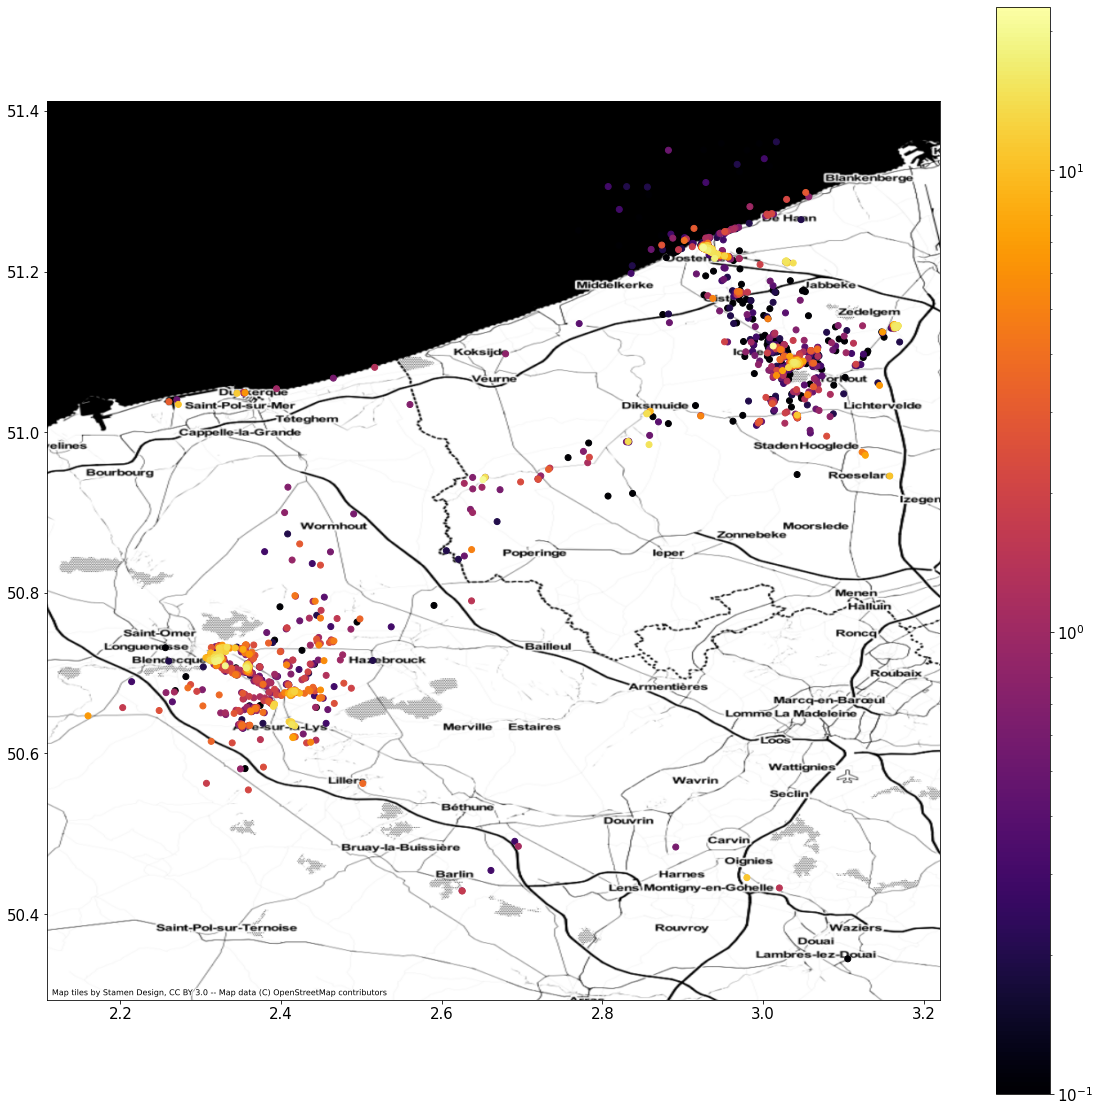

In [18]:
ax = stop_locations[stop_locations.OrganismID == birds[0]].sort_values(by="duration_h")\
    .plot(
        column="duration_h",
        cmap="inferno",
        figsize=(20,20),
        norm = LogNorm(),
        legend=True,
        vmax=20
    )
ctx.add_basemap(
    ax, 
    crs = stop_locations.crs.to_string(),
    source = ctx.providers.Stamen.Toner
)


When is the bird moving around a lot, and when is it resting?

(0.0, 15.0)

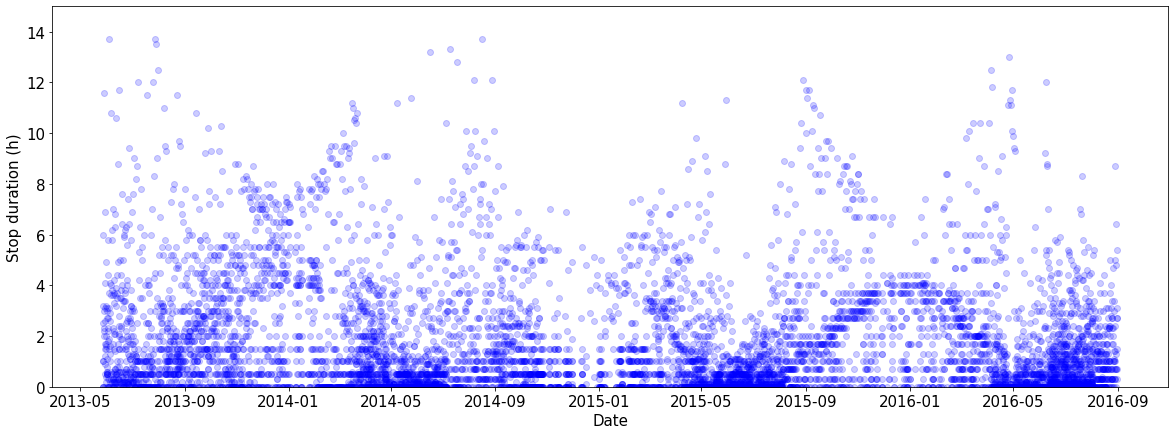

In [30]:
plt.figure(figsize=(20,7))
plt.plot(
    [datetime.fromtimestamp(t) for t in stop_locations[stop_locations.OrganismID == birds[4]]["min_ts"]],
    stop_locations[stop_locations.OrganismID == birds[4]]["duration_h"],
    'bo',
    alpha=0.2
)
plt.xlabel("Date")
plt.ylabel("Stop duration (h)")
plt.ylim(0,15)